In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score,RandomizedSearchCV
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler
from sklearn.naive_bayes import ComplementNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from scipy import stats
from sklearn.base import clone 
%matplotlib inline

C:\Users\dell\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
df.shape

(381109, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


There are no missing values in the dataset! Below are the dataset information


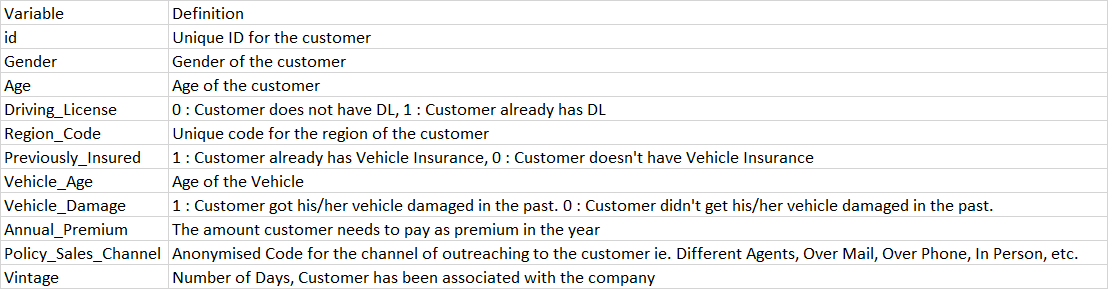

In [5]:
df.duplicated().sum() #There are no duplicate values in the dataset!

0

In [6]:
catg_features = ['Gender','Driving_License','Region_Code','Previsouly_Insured',
                'Vehicle_Damange','Policy_Sales_Channel']
num_fetaures = ['Age','Vehicle_Age','Annual_Premium','Vintage']
target_feature = ['Response']

# Data Preprocessing 

In [7]:
df.head(2)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0


In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df['Vehicle_Damage'] = le.fit_transform(df['Vehicle_Damage'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  int32  
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  int32  
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int32(2), int64(6), object(1)
memory usage: 32.0+ MB


#### Lets convert features into proper datatype
- Region_Code - should be converted into int instead of Float
- Vehicle_Age - should be converted into 3 labels instead of Object
- Policy_Sales_Channel - should be converted into int instead of Float

In [10]:
df['Region_Code'] = df['Region_Code'].astype('int32')
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('int32')


In [11]:
df['Vehicle_Age'] .unique()

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [12]:
df['Vehicle_Age'] = df['Vehicle_Age'].str.replace('Years','')
df['Vehicle_Age'] = df['Vehicle_Age'].str.replace('Year','')
df['Vehicle_Age'] = df['Vehicle_Age'].str.replace('>','')
df['Vehicle_Age'] = df['Vehicle_Age'].str.replace('<','')

In [13]:
def convert_vehicle_year(x):
    if x.strip() == '1':
        return 1
    elif x.strip() == '1-2':
        return 2
    elif x.strip() == '2':
        return 3
    else:
        return x

In [14]:
df['Vehicle_Age'] = df['Vehicle_Age'].apply(convert_vehicle_year)

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
Gender,381109.0,0.540761,0.498336,0.0,0.0,1.0,1.0,1.0
Age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
Driving_License,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
Region_Code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
Previously_Insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
Vehicle_Age,381109.0,1.609616,0.567439,1.0,1.0,2.0,2.0,3.0
Vehicle_Damage,381109.0,0.504877,0.499977,0.0,0.0,1.0,1.0,1.0
Annual_Premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
Policy_Sales_Channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0


Till here we have completed data pre-processing steps which includes:
- handling missing values
- handling categorical values
- handling duplicated values
- convert column to proper data types

Our main goal is to create two models i.e., Classification & Regression Model. Classification model will be responsible to get prediction on Response (0,1 Binary Classification). 

Regression Model will be responsible to predict Annual Premium. To create this model we also need to Scale the features and work with outliers if any.

<b>In below code first we will create classification model as we won't need to scale features in classification model. However few alogrithms are not robust to outliers in classfication model example Logistic Regression Model. We will work accordingly. Then we will create Regression Model

#### Exploratory Data Analysis

In [16]:
df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [17]:
catg_features = ['Region_Code','Policy_Sales_Channel']
Bool_features = ['Gender','Driving_License','Vehicle_Damage','Previously_Insured']
num_fetaures = ['Age','Vehicle_Age','Annual_Premium','Vintage']
target_feature = 'Response'

## Univariate Analysis

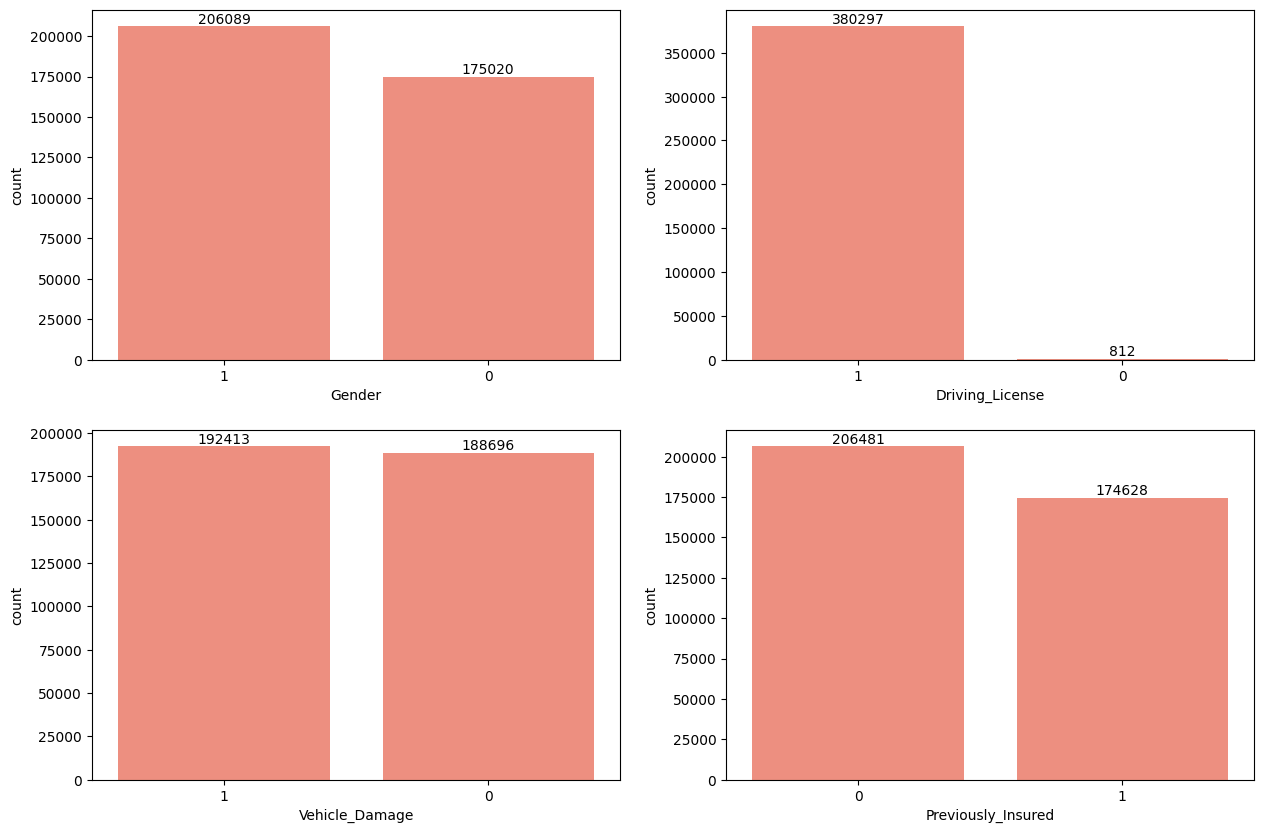

In [18]:
# Checking the distribution of the continuous features
fig, axes = plt.subplots(2, 2, figsize=(15,10))

# Original Distributions
for i, col in enumerate(Bool_features):
    if i<=1:
        ax = sns.countplot(x=df[col],
                       order=df[col].value_counts(ascending=False).index,ax=axes[0,i],color='#ff826e');
        abs_values = df[col].value_counts(ascending=False).values
        #abs_values = np.round(np.array(df.groupby(col).count()['id']/df.shape[0]),2)
        ax.bar_label(container=ax.containers[0], labels=abs_values)
    else:
        ax = sns.countplot(x=df[col],
                       order=df[col].value_counts(ascending=False).index,ax=axes[1,i-2],color='#ff826e');
        abs_values = df[col].value_counts(ascending=False).values
        #abs_values = np.round(np.array(df.groupby(col).count()['id']/df.shape[0]),2)
        ax.bar_label(container=ax.containers[0], labels=abs_values)



Above analysis shows below information:
- There are More male customer as compare to female customers
- Majority of customers have driving licence. There are only 812 customers who don't have a valid license
- There is equal proportionate to the section of customers whose vehicle has damaged.
- There are more list of customers who previously don't have insurance

[Text(0, 0, '334399'), Text(0, 0, '46710')]

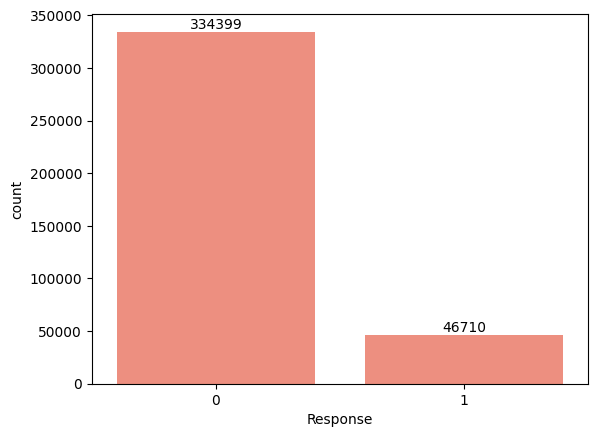

In [19]:
ax = sns.countplot(x=df[target_feature],
                   order=df[target_feature].value_counts(ascending=False).index,color='#ff826e');
abs_values = df[target_feature].value_counts(ascending=False).values
#abs_values = np.round(np.array(df.groupby(col).count()['id']/df.shape[0]),2)
ax.bar_label(container=ax.containers[0], labels=abs_values)

Above univariate analysis shows that our dataset is imbalanced as majority counts in zero response rate. This means that we cannot simply rely on accuracy metrics in classification model as out target values are imbalanced. Instead of we will need to decide which would be the best accuracy metric for this problem!

Since it is a problem where our main goal is to reduce False Negative numbers (Improve Recall %) where we don't want to provide insurance to those customers to whom we should have not provided the insurance. This means we need to redcue False Negative and get high Recall rate. Therefore our focus should be on recall rate as classification models' metric!

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  from ipykernel import kernelapp as app


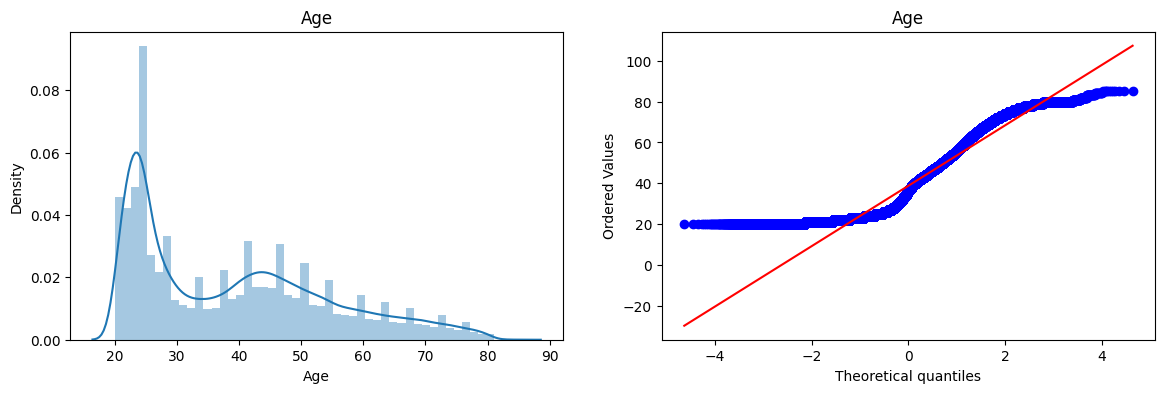

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  from ipykernel import kernelapp as app


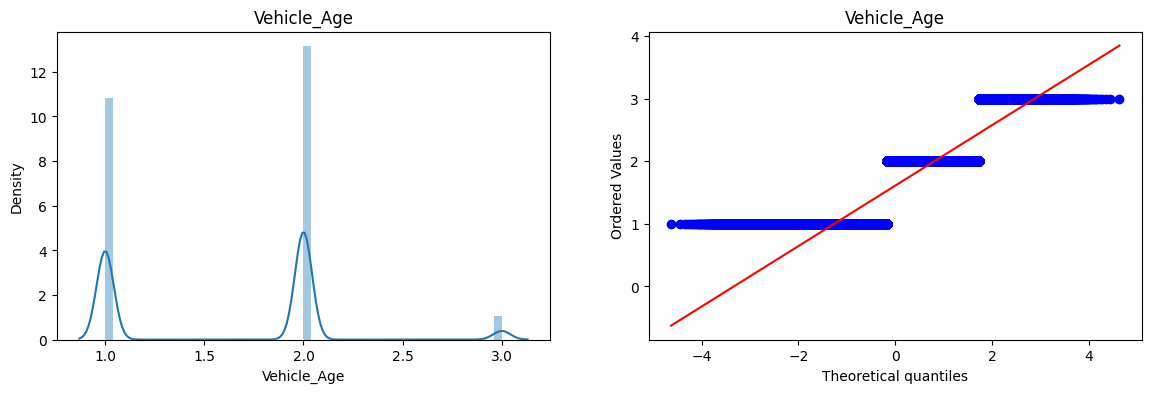

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  from ipykernel import kernelapp as app


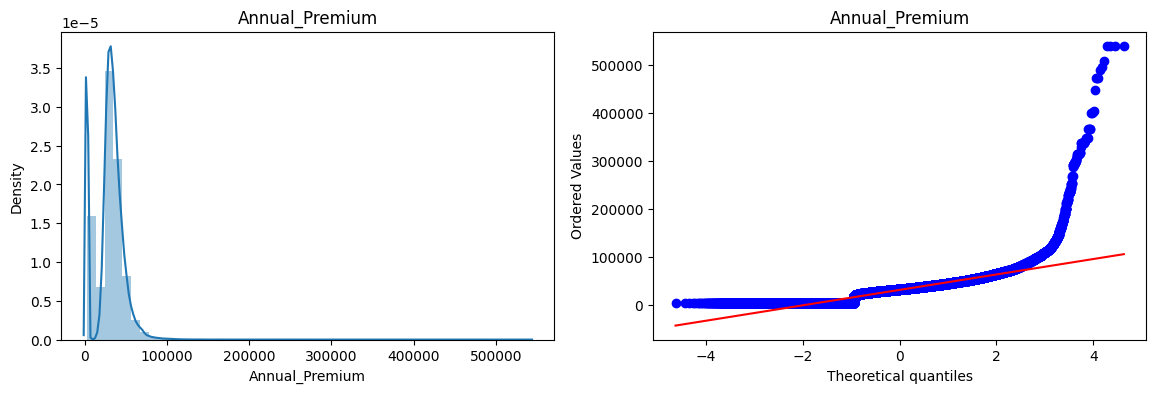

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  from ipykernel import kernelapp as app


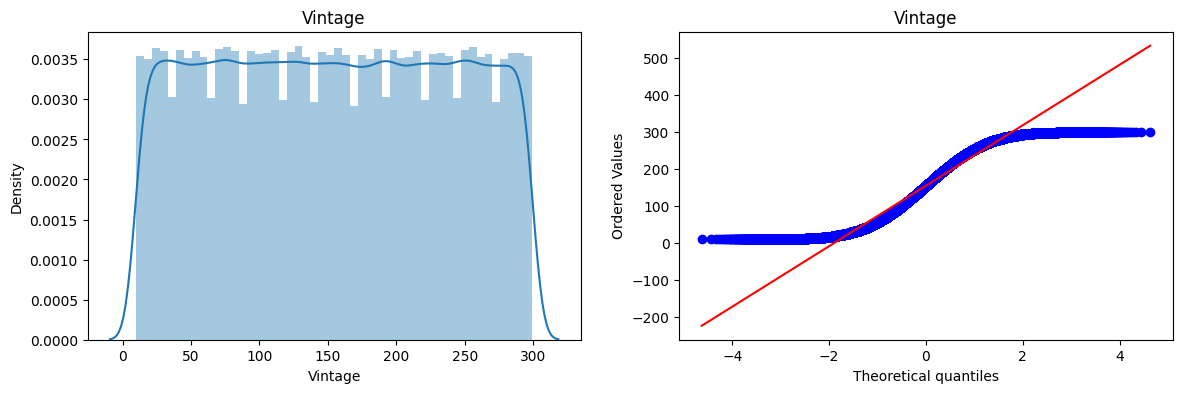

In [20]:
# Checking the distribution of the continuous features
import scipy.stats as stats
# fig, axes = plt.subplots(4, 2, figsize=(15,10))
# # Original Distributions
# for i, col in enumerate(num_fetaures):
#     sns.distplot(a=df[col],bins=40,norm_hist=True,ax=axes[i,0],color='#ff826e');
#     #plt.subplot(122)
#     stats.probplot(df[col], dist="norm", plot=plt,ax=axes[i,1])
#     plt.title('Age QQ Plot')
#     plt.show()

for col in num_fetaures:
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    sns.distplot(df[col])
    plt.title(col)

    plt.subplot(122)
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.title(col)

    plt.show()

In [21]:
import warnings
warnings.filterwarnings('ignore')

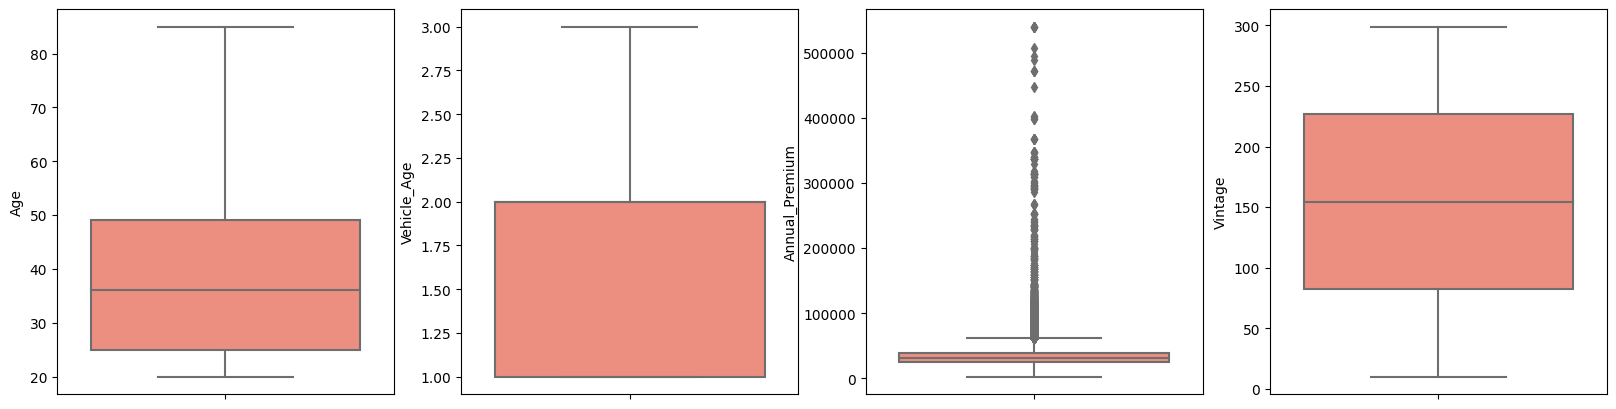

In [22]:
# Checking the outliers distribution of the continuous features
import scipy.stats as stats
fig, axes = plt.subplots(1, 4, figsize=(20,5))
# Original Distributions
for i, col in enumerate(num_fetaures):
    sns.boxplot(data=df,y=col,hue='Response',ax=axes[i],color='#ff826e');


Above analysis shows that Annual Premium has lot of outliers in the dataset. If we will use tree based algorithm then these outliers will not impact the result. Let's create two classification models i.e., with scaling and without scaling.

In [30]:
outliers_indexes = []
target = 'Response'

#For object features first we will fiter unique category in that column
#and then find q3 & q1 in respect to selling price column.

        
#For continuos column we will find out q3 & q1 in respect to that column itself        
for col in num_fetaures:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    maximum = q3 + (1.5 * iqr)
    minimum = q1 - (1.5 * iqr)
    outlier_samples = df[(df[col] < minimum) | (df[col] > maximum)]
    outliers_indexes.extend(outlier_samples.index.tolist())
    
outliers_indexes = list(set(outliers_indexes))
print('{} outliers were identified based on IQR Method, whose indices are:\n\n{}'.format(len(outliers_indexes), outliers_indexes))

10320 outliers were identified based on IQR Method, whose indices are:

[163843, 360452, 98315, 32784, 360465, 32786, 25, 131104, 196643, 37, 229424, 32817, 360503, 163900, 229442, 67, 262210, 131141, 65608, 294986, 294989, 229455, 65620, 32855, 163929, 32861, 229470, 360545, 360546, 98403, 32874, 65645, 196717, 229485, 229492, 196727, 163960, 295038, 131202, 196738, 196740, 360584, 139, 163982, 98450, 163988, 149, 131222, 262298, 65693, 98461, 360609, 32934, 167, 98476, 176, 196786, 32958, 164031, 32960, 295102, 131270, 131275, 262350, 327887, 360659, 229589, 216, 164061, 360675, 327911, 65768, 262379, 262381, 98542, 164078, 229614, 229617, 360687, 164089, 98555, 295163, 196869, 295174, 98569, 33037, 131345, 360725, 65821, 295199, 295204, 98598, 327974, 262440, 360746, 262447, 131378, 131380, 310, 295224, 315, 131387, 131388, 229693, 262464, 360769, 262466, 131398, 229703, 196940, 65870, 131419, 295259, 328038, 328040, 362, 33134, 328048, 65908, 131446, 375, 196983, 229752, 360824, 19

In [31]:
#lets check how many outliers are there in Annual Premium feature
outlier_indexes = df[stats.zscore(df['Annual_Premium'])>3].index
#df.drop(outlier_indexes, inplace=True)
#df.reset_index(drop=True, inplace=True)
print(len(outlier_indexes))

2083


In [32]:
outlier_indexes = df[stats.zscore(df['Annual_Premium'])>3].index
df.drop(outlier_indexes, inplace=True)
df.reset_index(drop=True, inplace=True)

Above analysis shows that each numerical features are either positive or negatvie skewed. None of the numerical column is perfectly normally distributed!

## Bivariate Analysis 

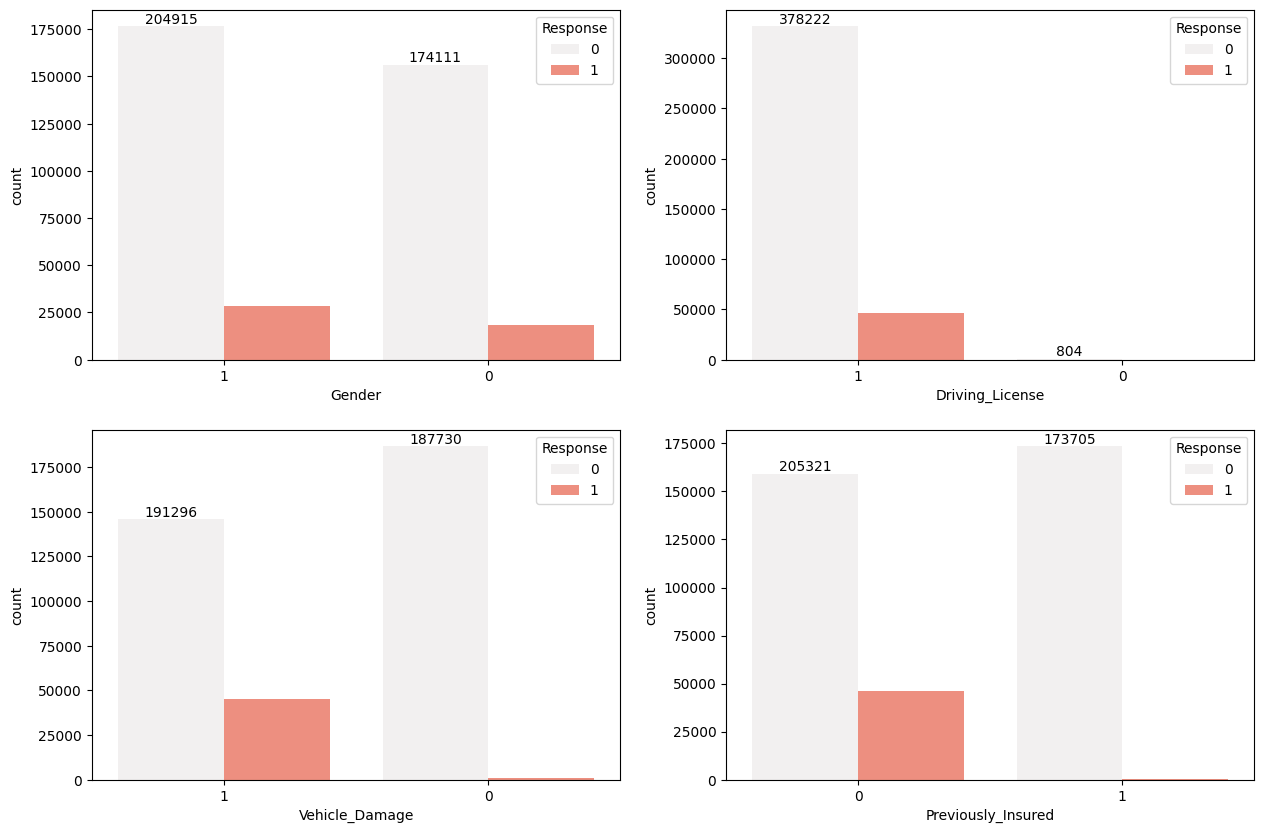

In [33]:
# Checking the distribution of the continuous features
fig, axes = plt.subplots(2, 2, figsize=(15,10))

# Original Distributions
for i, col in enumerate(Bool_features):
    if i<=1:
        ax = sns.countplot(x=df[col],
                       order=df[col].value_counts(ascending=False).index,ax=axes[0,i],hue=df['Response'],color='#ff826e');
        abs_values = df[col].value_counts(ascending=False).values
        #abs_values = np.round(np.array(df.groupby(col).count()['id']/df.shape[0]),2)
        ax.bar_label(container=ax.containers[0], labels=abs_values)
    else:
        ax = sns.countplot(x=df[col],
                       order=df[col].value_counts(ascending=False).index,hue=df['Response'],ax=axes[1,i-2],color='#ff826e');
        abs_values = df[col].value_counts(ascending=False).values
        #abs_values = np.round(np.array(df.groupby(col).count()['id']/df.shape[0]),2)
        ax.bar_label(container=ax.containers[0], labels=abs_values)



Below are the data Insights:
- Male and Female is not impacting much on response rate.
- Response rate is positive only for those customers who is having valid driving license.
- Response rate is positive for those customers who has past vehicle damage.
- Response rate is positive for those customers who are not previously insured.

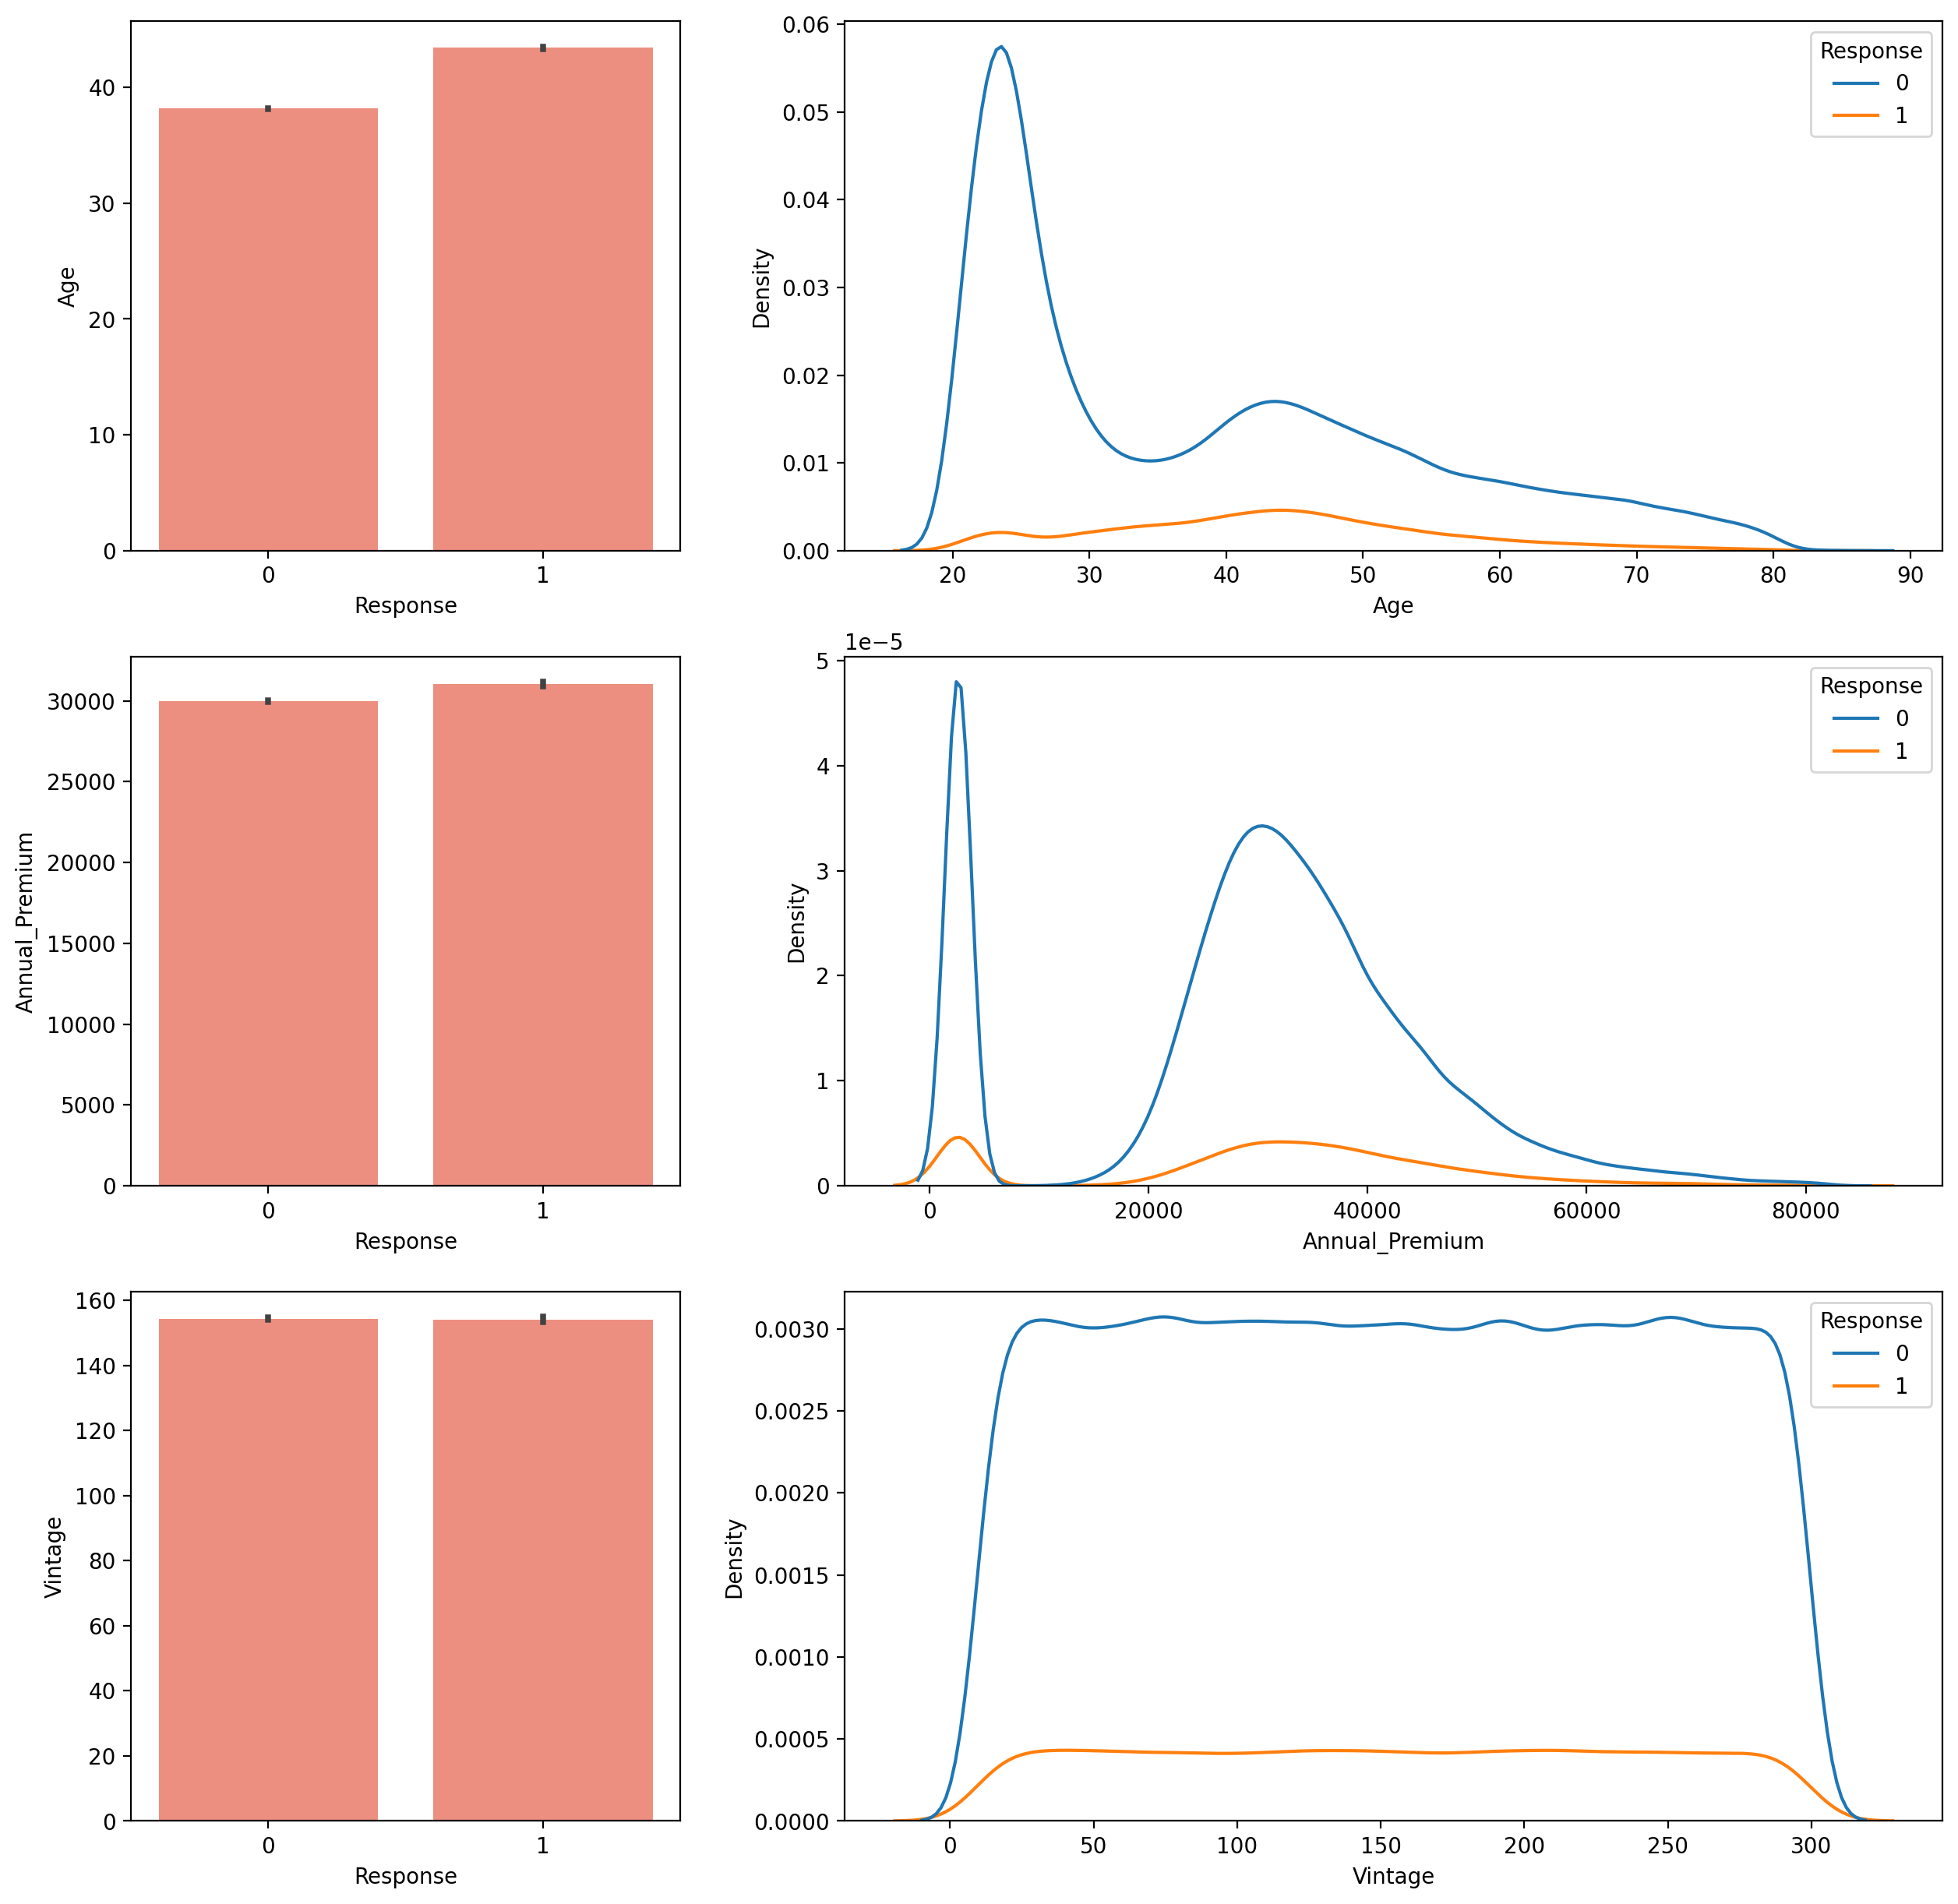

In [34]:
num_fetaures = ['Age','Annual_Premium','Vintage']
# Checking the distribution of the continuous features
fig, ax = plt.subplots(3, 2, figsize=(15,15), dpi=200, gridspec_kw={'width_ratios': [1, 2]})

# Define the target name in a variable for simplicity
Target = 'Response'

# Original Distributions
for i, col in enumerate(num_fetaures):
    sns.barplot(data=df,x=Target,y=col,ax=ax[i,0], color='#ff826e')
    sns.kdeplot(data=df,x=col,ax=ax[i,1],hue=Target)   


<AxesSubplot:>

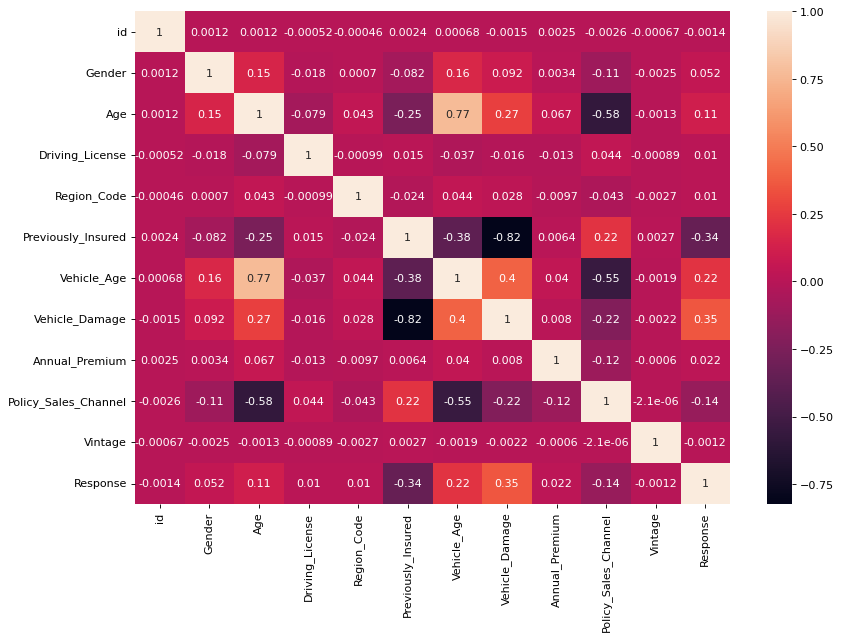

In [35]:
plt.figure(figsize=(12,8), dpi=80)
sns.heatmap(df.corr(),annot=True)

# Classificatoin Model Building 

In [36]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,1,44,1,28,0,3,1,40454.0,26,217,1
1,2,1,76,1,3,0,2,0,33536.0,26,183,0
2,3,1,47,1,28,0,3,1,38294.0,26,27,1
3,4,1,21,1,11,1,1,0,28619.0,152,203,0
4,5,0,29,1,41,1,1,0,27496.0,152,39,0


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X = df.drop(['Response','id','Policy_Sales_Channel'],axis=1)
y = df['Response']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,random_state=0,stratify=y)

X_train_transformed = sc.fit_transform(X_train)
X_test_transformed = sc.transform(X_test)

columns = X_train.columns.tolist()
X_train_transformed = pd.DataFrame(data = X_train_transformed,columns=columns)
X_test_transformed = pd.DataFrame(data = X_test_transformed,columns=columns)

In [45]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train):
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
    clf_grid = RandomizedSearchCV(estimator=clf,param_distributions=param_grid,cv=cv,scoring=f1_metric,n_jobs=-1)
    clf_grid.fit(X_train,y_train)
    print('Done')
    print(f'Best Hypermarameters:\n',clf_grid.best_params_)
    return clf_grid.best_estimator_

In [46]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='binary'),
                                recall_score(y_test, y_pred, average='binary'),
                                f1_score(y_test, y_pred, average='binary'),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[::,1])],
                          index=['Accuracy','Precision','Recall','F1-score','AUC'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [47]:
def drop_column_importance(model, X_train, y_train, random_state=0):
    # list containing feature importances
    importances = []
    # Clone the model
    model_clone = clone(model)
    # Set random_state for comparability
    model_clone.random_state = random_state
    # Train the model
    model_clone.fit(X_train, y_train)
    # Create the cross-validation object using StratifiedKFold 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    # Score the benchmark model using cross-validation
    benchmark_score = cross_val_score(model_clone, X_train, y_train, cv=cv, scoring=f1_metric,n_jobs=-1).mean()

    print('BenchmarkDone')
    # Iterate over all features and store feature importance
    for col in X_train.columns:
        # Clone the model
        model_clone = clone(model)
        # Set random_state for comparability
        model_clone.random_state = random_state
        # Traint the model on the the dataset with a single feature removed
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        # Score the droped-column model
        drop_column_score = cross_val_score(model_clone, X_train.drop(col,axis=1), y_train, cv=cv, scoring=f1_metric,n_jobs=-1).mean()
        # Store feature importance which is defined as the difference between the benchmark and the new model score
        importances.append(benchmark_score - drop_column_score)
    
    print('Done')
    # Return the features along with their importances in the form of a dataframe
    importances_df = pd.DataFrame({'feature': X_train.columns, 'feature importance': importances}) \
                     .sort_values('feature importance', ascending = False).reset_index(drop = True)
           
    return importances_df   

In [48]:
# Define a scorer function
def f1_metric(model, X_train, y_train):
    '''
    This function reports f1-score metric for the class specified by 'Positive Label' (or '1')
    '''
    return f1_score(y_train, model.predict(X_train), average='binary')

In [49]:
def drop_column_importance_plot(model, X_train, y_train):
    # Call drop-column feature importance function
    df_drop_column = drop_column_importance(model, X_train, y_train, random_state=0)
    # Rename columns
    df_drop_column.columns = ['Feature', 'Feature Importance']
    
    # Plot barchart
    plt.figure(figsize=(12,10))
    sns.barplot(data=df_drop_column, x='Feature Importance', y='Feature', orient='h', color='royalblue')
    plt.title('Drop Column Feature Importance', fontsize=20)
    plt.show()

In [50]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Plot confusion matrix for test set
    # Define a colormap
    royalblue = LinearSegmentedColormap.from_list('royalblue', [(0, (1,1,1)), (1, (0.25,0.41,0.88))])
    royalblue_r = royalblue.reversed()
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, cmap=royalblue_r, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show() 

## Logistic Regression Model Building

In [51]:
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.01,0.5,20)]

# Define hyperparameters grid
param_grid = [{'solver':['lbfgs', 'newton-cg', 'sag', 'saga'], 
               'C': np.logspace(-5, 5, 10),
               'penalty':['none','l2'], 
               'class_weight':class_weights}]
              
              

In [52]:
# Define the base model

logreg = LogisticRegression(max_iter=500)

# Call tune_clf_hyperparameters function to find the optimal combination of hyperparameters 
logreg_opt = tune_clf_hyperparameters(logreg, param_grid, X_train, y_train)

Done
Best Hypermarameters:
 {'solver': 'newton-cg', 'penalty': 'l2', 'class_weight': {0: 0.16473684210526315, 1: 0.8352631578947368}, 'C': 100000.0}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.60      0.75    166319
           1       0.25      0.95      0.40     23194

    accuracy                           0.65    189513
   macro avg       0.62      0.78      0.57    189513
weighted avg       0.90      0.65      0.71    189513


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.60      0.75    166319
           1       0.25      0.95      0.40     23194

    accuracy                           0.65    189513
   macro avg       0.62      0.78      0.57    189513
weighted avg       0.90      0.65      0.71    189513



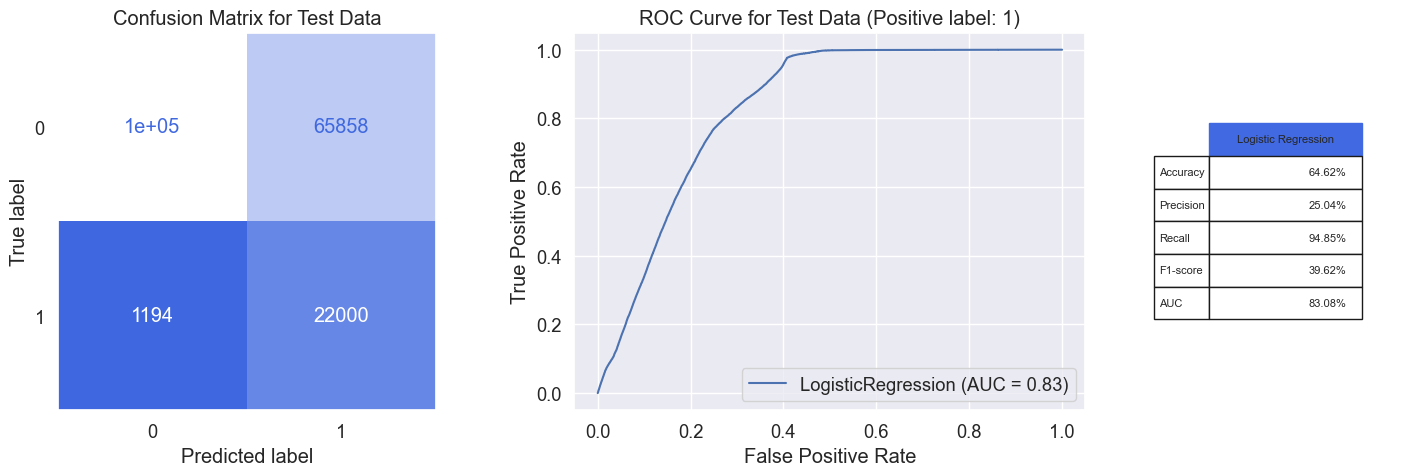

In [58]:
model_evaluation(logreg_opt, X_train, X_test, y_train, y_test, 'Logistic Regression')

Above Analysis shows that we are getting f1 score with 40% and AUC with 83%. This could be the best model but also lets try other model and save this one.

In [60]:
# Save the final performance of Logistic Regression classifier
logreg_result = metrics_calculator(logreg_opt, X_test, y_test, 'Logistic Regression')
logreg_result

,Logistic Regression
Accuracy,64.62%
Precision,25.04%
Recall,94.85%
F1-score,39.62%
AUC,83.08%


In [61]:
import pickle
pickle.dump(logreg_opt,open('LogisticRegressionModel.pkl','wb'))

## Logistic Regression with Features Scaling 

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X = df.drop(['Response','id','Policy_Sales_Channel'],axis=1)
y = df['Response']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,random_state=0,stratify=y)

X_train_transformed = sc.fit_transform(X_train)
X_test_transformed = sc.transform(X_test)

columns = X_train.columns.tolist()
X_train_transformed = pd.DataFrame(data = X_train_transformed,columns=columns)
X_test_transformed = pd.DataFrame(data = X_test_transformed,columns=columns)

In [63]:
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.01,0.5,20)]

# Define hyperparameters grid
param_grid = [{'solver':['lbfgs', 'newton-cg', 'sag', 'saga'], 
               'C': np.logspace(-5, 5, 10),
               'penalty':['none','l2'], 
               'class_weight':class_weights}]
              
# Define the base model

logreg = LogisticRegression(max_iter=500)

# Call tune_clf_hyperparameters function to find the optimal combination of hyperparameters 
logreg_opt = tune_clf_hyperparameters(logreg, param_grid, X_train_transformed, y_train)              

Done
Best Hypermarameters:
 {'solver': 'sag', 'penalty': 'none', 'class_weight': {0: 0.24210526315789474, 1: 0.7578947368421053}, 'C': 1e-05}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.80      0.87    166319
           1       0.31      0.65      0.42     23194

    accuracy                           0.78    189513
   macro avg       0.63      0.73      0.64    189513
weighted avg       0.87      0.78      0.81    189513


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.80      0.87    166319
           1       0.31      0.65      0.42     23194

    accuracy                           0.78    189513
   macro avg       0.63      0.73      0.64    189513
weighted avg       0.87      0.78      0.81    189513



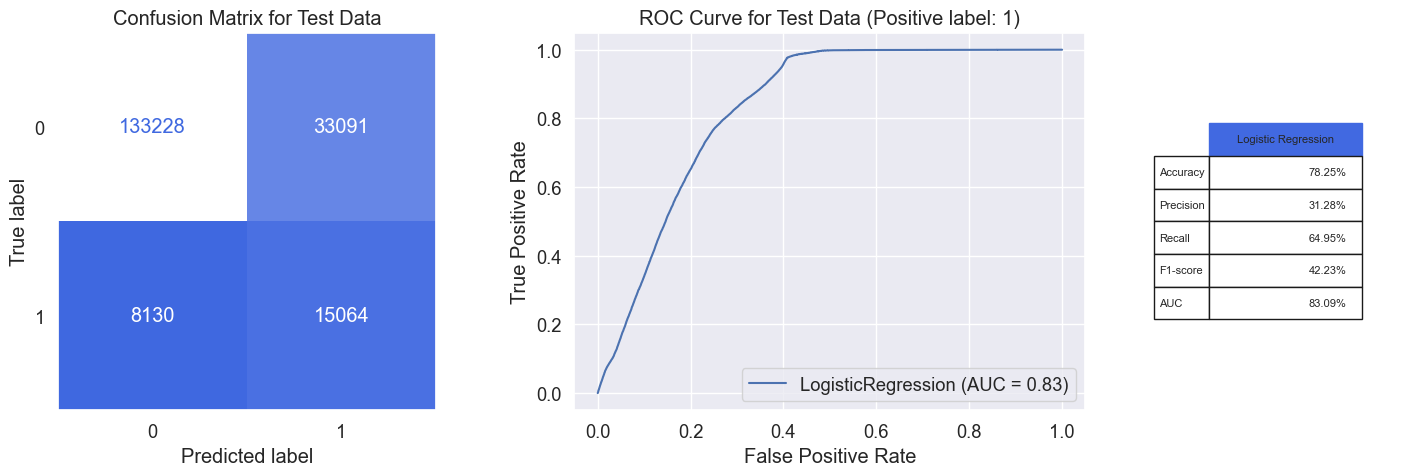

In [64]:
model_evaluation(logreg_opt, X_train_transformed, X_test_transformed, y_train, y_test, 'Logistic Regression')

Logistic Regression with Feature Scaling has increased the Precision score with 6% but reduced Recall with approx 20%. AUC is more or less similar. we will also save this model for future reference

In [69]:
# Save the final performance of Logistic Regression classifier
logreg_result_featurescaling = metrics_calculator(logreg_opt, X_test_transformed, y_test, 'Logistic Regression')
logreg_result_featurescaling

,Logistic Regression
Accuracy,78.25%
Precision,31.28%
Recall,64.95%
F1-score,42.23%
AUC,83.09%


In [70]:
import pickle
pickle.dump(logreg_opt,open('LogisticRegressionModel_FeatureScaling.pkl','wb'))

## Decision Tree - Model Building 

In [72]:
# Weights associated with classes
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,1,20)]
    
# Define the hyperparameter grid
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': np.arange(1, 10),
              'min_samples_split': np.arange(1, 10),
              'min_samples_leaf': np.arange(1, 10),
              'max_features': [None, 'sqrt', 'log2'],
              'class_weight': class_weights} 

# Perform train test split
X = df.drop(['Response','id','Policy_Sales_Channel'],axis=1)
y = df['Response']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

# Create a  Decision Tree Classifier object
dt = DecisionTreeClassifier(random_state=0)

# Find the best classifier with the optimal hyperparameters
dt_opt = tune_clf_hyperparameters(dt, param_grid, X_train, y_train)

Done
Best Hypermarameters:
 {'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'gini', 'class_weight': {0: 0.2113157894736842, 1: 0.7886842105263158}}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.76      0.85    266110
           1       0.31      0.77      0.44     37110

    accuracy                           0.76    303220
   macro avg       0.63      0.77      0.65    303220
weighted avg       0.88      0.76      0.80    303220


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.76      0.85     66528
           1       0.30      0.77      0.44      9278

    accuracy                           0.76     75806
   macro avg       0.63      0.76      0.64     75806
weighted avg       0.88      0.76      0.80     75806



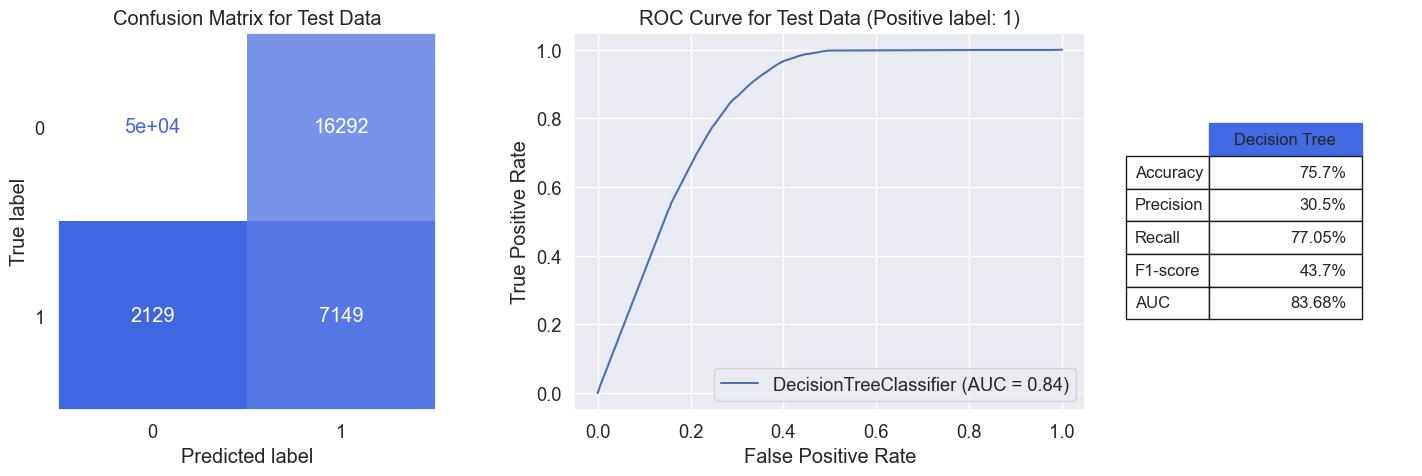

In [73]:
model_evaluation(dt_opt, X_train, X_test, y_train, y_test, 'Decision Tree')

Decision Tree model is giving very good recall rate. But it is not improving Precision & F1-Score. AUC is 83%. Also analysis shows that our model is not overtrained as precision & recall is not impacting much on Test dataset!

In [76]:
# Save the final performance of Decision Tree classifier
dt_result = metrics_calculator(dt_opt, X_test, y_test, 'Decision Tree')

pickle.dump(dt_opt,open('DecisionTreeModel.pkl','wb'))
dt_result

,Decision Tree
Accuracy,75.7%
Precision,30.5%
Recall,77.05%
F1-score,43.7%
AUC,83.68%


In [78]:
# Weights associated with classes
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,1,20)]

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150], 
    'max_depth': np.arange(5, 12),
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': class_weights
}

# Perform train test split
X = df.drop(['Response','id','Policy_Sales_Channel'],axis=1)
y = df['Response']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

# Create a random forest classifier object
rf = RandomForestClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
rf_opt = tune_clf_hyperparameters(rf, param_grid, X_train, y_train)

Done
Best Hypermarameters:
 {'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 7, 'class_weight': {0: 0.2113157894736842, 1: 0.7886842105263158}}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.75      0.84    266110
           1       0.31      0.80      0.45     37110

    accuracy                           0.76    303220
   macro avg       0.64      0.78      0.65    303220
weighted avg       0.88      0.76      0.80    303220


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     66528
           1       0.31      0.80      0.44      9278

    accuracy                           0.75     75806
   macro avg       0.64      0.77      0.64     75806
weighted avg       0.88      0.75      0.79     75806



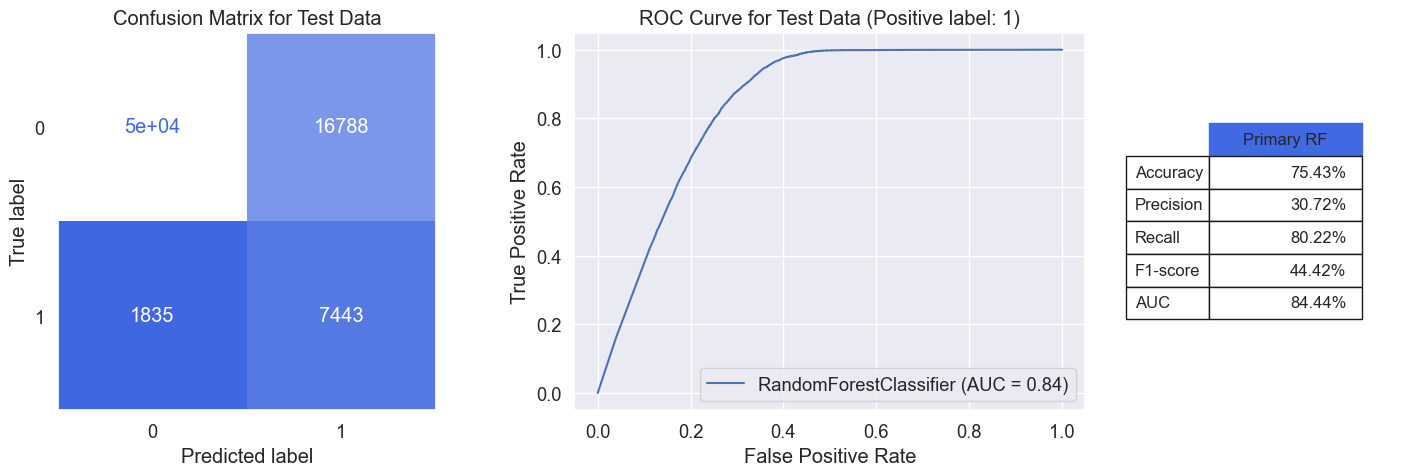

In [79]:
model_evaluation(rf_opt, X_train, X_test, y_train, y_test, 'Primary RF')

Above analysis shows that our model in not overfitted. Random Forest model is giving 80% recall score with 75.43% accuracy. Also F1-score slightly improve to 44.42. AUC hasn't impacted much. It is still ranging between 85%. We need to test other models also

In [82]:
# Save the final performance of Random Forest classifier
rf_result = metrics_calculator(rf_opt, X_test, y_test, 'Random Forest')

pickle.dump(rf_opt,open('DecisionTreeModel.pkl','wb'))
rf_result

,Random Forest
Accuracy,75.43%
Precision,30.72%
Recall,80.22%
F1-score,44.42%
AUC,84.44%


## Extra Trees -  Model Building

In [83]:
# Weights associated with classes
class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,1,20)]

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [70, 100, 150], 
    'max_depth': [10,12,14],
    'min_samples_split': [1,2,3],
    'min_samples_leaf': [1,2,3],
    'class_weight': class_weights
}

# Perform train test split
X = df.drop(['Response','id','Policy_Sales_Channel'],axis=1)
y = df['Response']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

# Create a random forest classifier object
et = ExtraTreesClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
et_opt = tune_clf_hyperparameters(et, param_grid, X_train, y_train)

Done
Best Hypermarameters:
 {'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 12, 'class_weight': {0: 0.26389473684210524, 1: 0.7361052631578948}}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.81      0.87    266110
           1       0.34      0.70      0.45     37110

    accuracy                           0.79    303220
   macro avg       0.64      0.75      0.66    303220
weighted avg       0.88      0.79      0.82    303220


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.80      0.87     66528
           1       0.33      0.68      0.44      9278

    accuracy                           0.79     75806
   macro avg       0.64      0.74      0.65     75806
weighted avg       0.87      0.79      0.82     75806



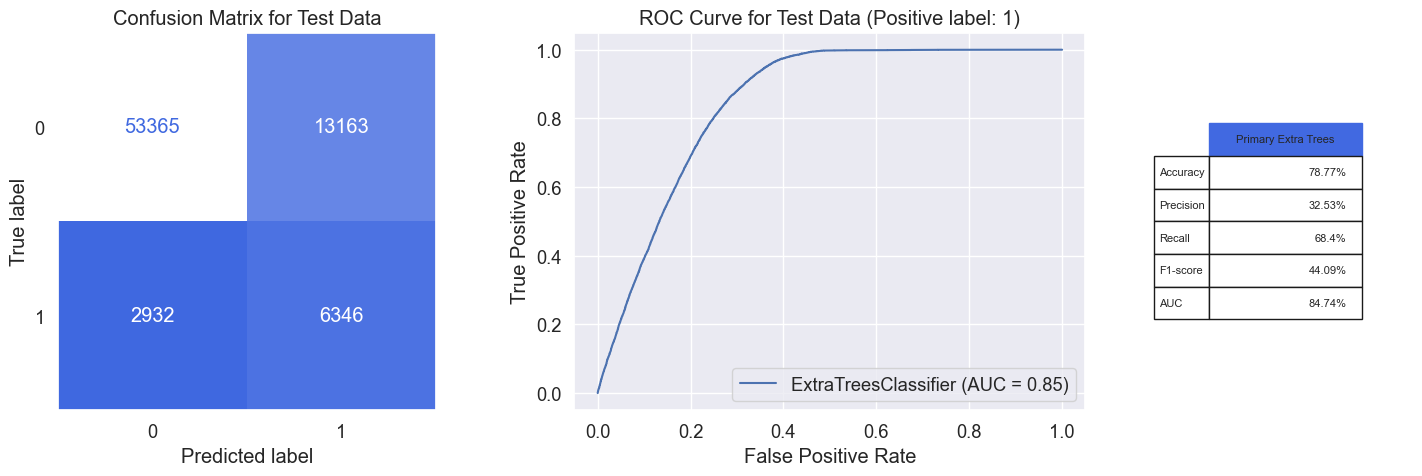

In [84]:
model_evaluation(et_opt, X_train, X_test, y_train, y_test, 'Primary Extra Trees')

The comparison of precision, recall, and f1-score for class 1 between the training and test datasets suggests that the model is slightly overfit. If the values for class 1 show a significant decrease in performance on the test set compared to the training set, it indicates that the model has learned the training data too well and has not generalized well to new unseen data. This overfitting leads to a poor performance on the test set and suggests that the model is not suitable for making accurate predictions on new data.

Based on the explanation given in section 15.3, by increasing the value of min_samples_leaf from 2 to 3, the model becomes less complex and the variance of the model is reduced:

 {'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 12, 'class_weight': {0: 0.26389473684210524, 1: 0.7361052631578948}}

In [87]:
# Build Extra Trees classifier object considering the obtained optimal values for hyperparameters
et_final = ExtraTreesClassifier(criterion='gini', max_features=None, bootstrap=True,  n_estimators=70, 
                                max_depth = 14,  min_samples_leaf=1, min_samples_split=3,
                                class_weight= {0: 0.26389473684210524, 1: 0.7361052631578948}, random_state=0)
                             
     
        
        
# Train the final Extra Trees model
et_final.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True,
                     class_weight={0: 0.26389473684210524,
                                   1: 0.7361052631578948},
                     max_depth=14, max_features=None, min_samples_split=3,
                     n_estimators=70, random_state=0)


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.82      0.88    266110
           1       0.35      0.70      0.47     37110

    accuracy                           0.81    303220
   macro avg       0.65      0.76      0.68    303220
weighted avg       0.88      0.81      0.83    303220


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     66528
           1       0.33      0.66      0.44      9278

    accuracy                           0.79     75806
   macro avg       0.64      0.73      0.65     75806
weighted avg       0.87      0.79      0.82     75806



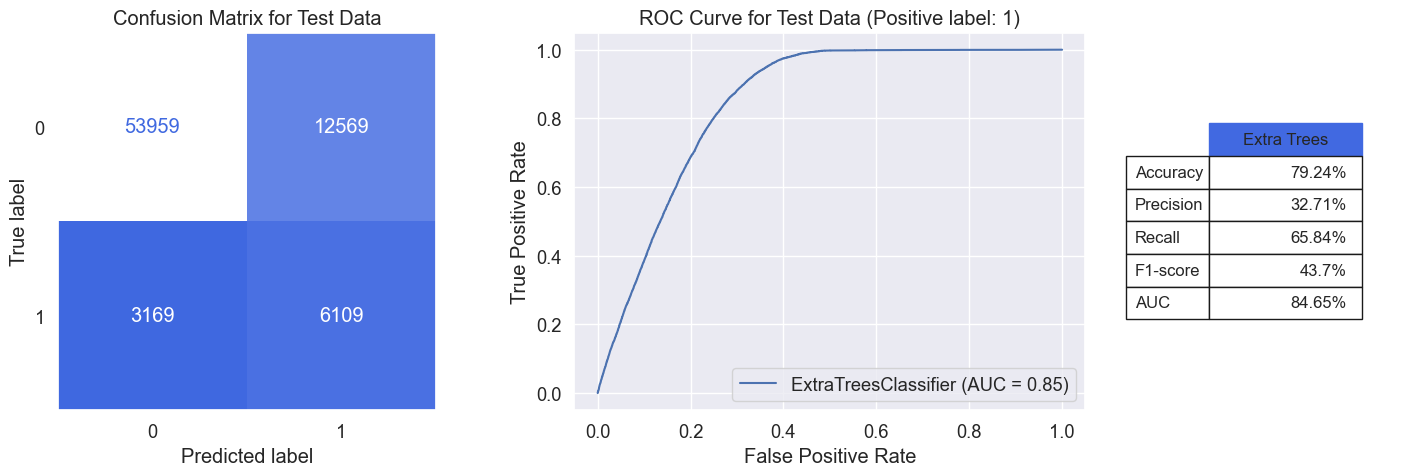

In [88]:
model_evaluation(et_final, X_train, X_test, y_train, y_test, 'Extra Trees')

In [89]:
# Save the final performance of Extra Trees classifier
et_result = metrics_calculator(et_final, X_test, y_test, 'Extra Trees')
et_result
import pickle
pickle.dump(et_final,open('ExtraTreeClassifier.pkl','wb'))
et_result

,Extra Trees
Accuracy,79.24%
Precision,32.71%
Recall,65.84%
F1-score,43.7%
AUC,84.65%


## AdaBoost Model Building

In [91]:
# Define the hyperparameter grid for AdaBoost
ada_param_grid = {
    'base_estimator__max_depth': [3, 5, 7],
    'base_estimator__min_samples_split': [3, 5, 7],
    'base_estimator__min_samples_leaf': [1, 2, 3],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.8, 0.9, 1]
}

# Perform train test split
X = df.drop(['Response','id','Policy_Sales_Channel'],axis=1)
y = df['Response']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

# Create the Decision Tree classifier as the base estimator
dt = DecisionTreeClassifier(criterion='gini', max_features=None, random_state=0)

# Create the AdaBoost classifier using Decision Tree as base estimator
ada = AdaBoostClassifier(base_estimator=dt, random_state=0)

# Find the best AdaBoost classifier with the optimal hyperparameters
ada_opt = tune_clf_hyperparameters(ada, ada_param_grid, X_train, y_train)

Done
Best Hypermarameters:
 {'n_estimators': 150, 'learning_rate': 0.8, 'base_estimator__min_samples_split': 5, 'base_estimator__min_samples_leaf': 2, 'base_estimator__max_depth': 7}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.99      0.94    266110
           1       0.78      0.22      0.35     37110

    accuracy                           0.90    303220
   macro avg       0.84      0.61      0.65    303220
weighted avg       0.89      0.90      0.87    303220


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.97      0.93     66528
           1       0.32      0.09      0.13      9278

    accuracy                           0.87     75806
   macro avg       0.60      0.53      0.53     75806
weighted avg       0.82      0.87      0.83     75806



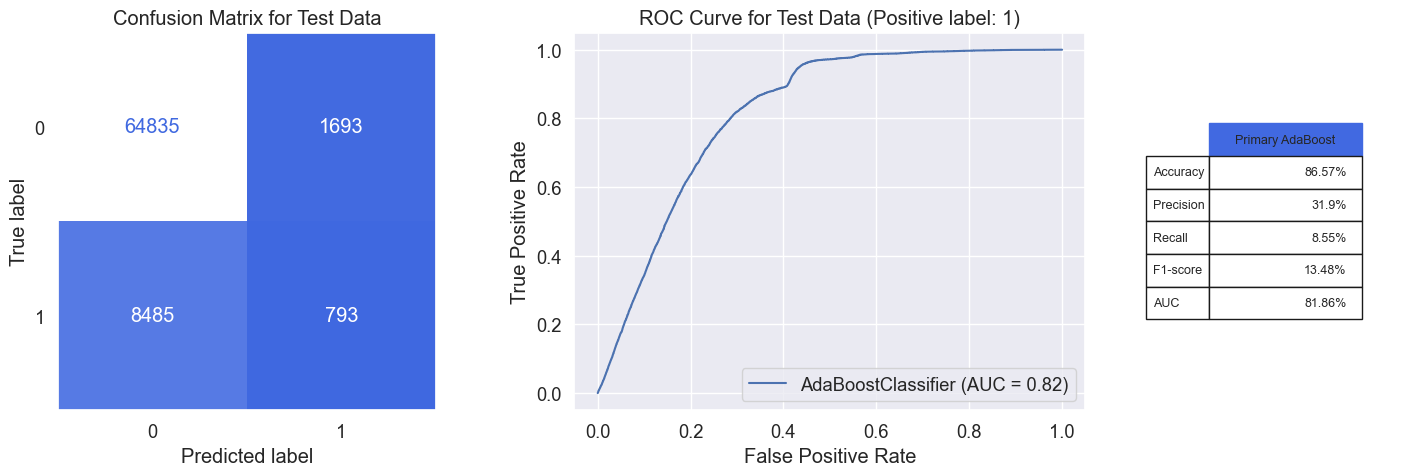

In [92]:
model_evaluation(ada_opt, X_train, X_test, y_train, y_test, 'Primary AdaBoost')

Adaboost model has reduced F1 score too low and also not giving good recall & precision score. It is not good fit model for us! It is an overtrained model. Lets try to do some more heyperparameter tuning to see if we can improve the recall & f1 score

In [93]:
# Create the Decision Tree classifier as the base estimator
dt = DecisionTreeClassifier(criterion='gini', max_features=None, random_state=0, max_depth=5, min_samples_leaf=2, min_samples_split=5)

# Create the AdaBoost classifier using Decision Tree as base estimator
ada_final = AdaBoostClassifier(base_estimator=dt, random_state=0, learning_rate=0.02, n_estimators=1000)

# Train the final AdaBoost classifier
ada_final.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                         min_samples_leaf=2,
                                                         min_samples_split=5,
                                                         random_state=0),
                   learning_rate=0.02, n_estimators=1000, random_state=0)


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.94    266110
           1       0.95      0.02      0.04     37110

    accuracy                           0.88    303220
   macro avg       0.92      0.51      0.49    303220
weighted avg       0.89      0.88      0.83    303220


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66528
           1       0.41      0.01      0.01      9278

    accuracy                           0.88     75806
   macro avg       0.64      0.50      0.47     75806
weighted avg       0.82      0.88      0.82     75806



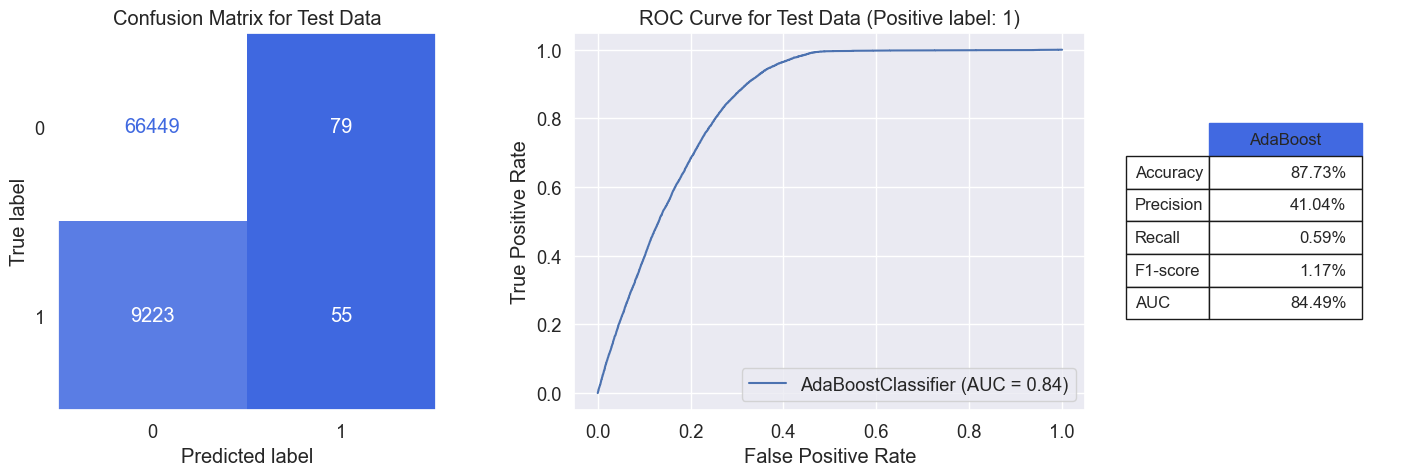

In [94]:
model_evaluation(ada_final, X_train, X_test, y_train, y_test, 'AdaBoost')

Above analysis shows that Adaboost Model is not giving good recall score. Also after tuning the model, it is still an overfitting model

In [127]:
# Save the final performance of AdaBoost classifier
ada_result = metrics_calculator(ada_final, X_test, y_test, 'AdaBoost')
pickle.dump(ada_final,open('Adaboost.pkl','wb'))
ada_result

,AdaBoost
Accuracy,87.73%
Precision,41.04%
Recall,0.59%
F1-score,1.17%
AUC,84.49%


## Gradient Boosting - Model Building

In [99]:
# Define the hyperparameter grid for AdaBoost
gbc_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'loss': ['deviance', 'exponential'],
    'criterion': ['friedman_mse', 'squared_error'],
    'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]
}


# Perform train test split
X = df.drop(['Response','id','Policy_Sales_Channel'],axis=1)
y = df['Response']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,random_state=0,stratify=y)

# Create the Decision Tree classifier as the base estimator
gbc = GradientBoostingClassifier(random_state=0)

# Find the best hyperparameters from the tuning process
gbc_opt = tune_clf_hyperparameters(gbc, gbc_param_grid, X_train, y_train)

Done
Best Hypermarameters:
 {'subsample': 0.2, 'n_estimators': 200, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 4, 'loss': 'deviance', 'learning_rate': 0.3, 'criterion': 'friedman_mse'}



	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    166319
           1       0.50      0.03      0.06     23194

    accuracy                           0.88    189513
   macro avg       0.69      0.51      0.49    189513
weighted avg       0.83      0.88      0.83    189513


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.99      0.93    166319
           1       0.36      0.02      0.04     23194

    accuracy                           0.88    189513
   macro avg       0.62      0.51      0.49    189513
weighted avg       0.82      0.88      0.82    189513



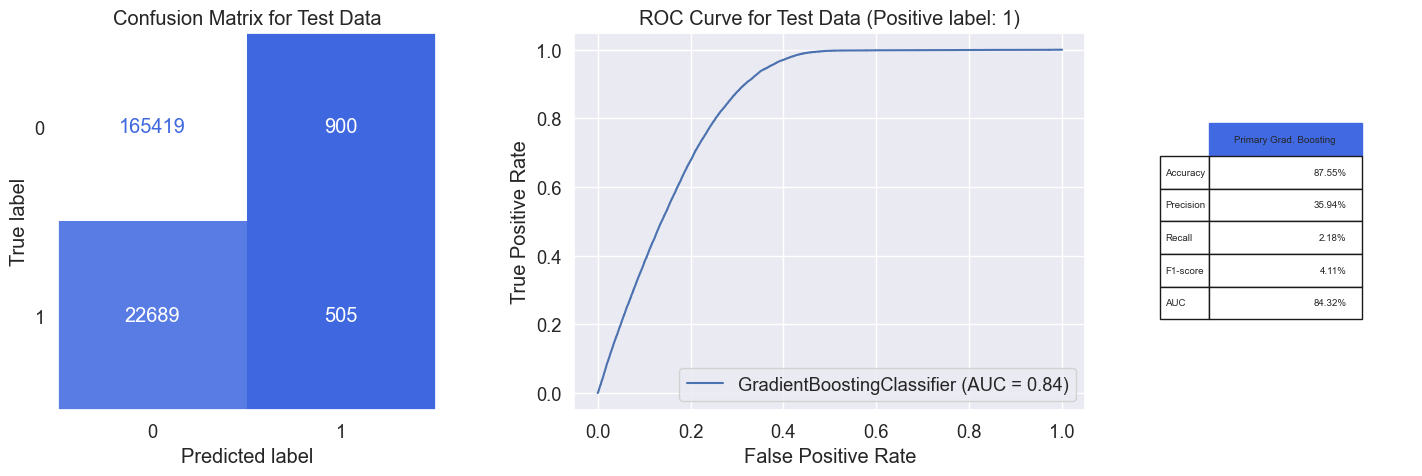

In [100]:
model_evaluation(gbc_opt, X_train, X_test, y_train, y_test, 'Primary Grad. Boosting')

In [98]:
# Initialize the Gradient Boosting Classifier
gbc_final = GradientBoostingClassifier(max_features=None, loss='deviance', criterion='friedman_mse',
                                 learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0,
                                 min_samples_leaf=4, min_samples_split=2, random_state=0)

# Train the final AdaBoost classifier
gbc_final.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, min_samples_leaf=4,
                           random_state=0)


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     66879
           1       0.89      0.03      0.06      9342

    accuracy                           0.88     76221
   macro avg       0.89      0.52      0.50     76221
weighted avg       0.88      0.88      0.83     76221


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    267520
           1       0.35      0.01      0.02     37368

    accuracy                           0.88    304888
   macro avg       0.61      0.50      0.48    304888
weighted avg       0.81      0.88      0.82    304888



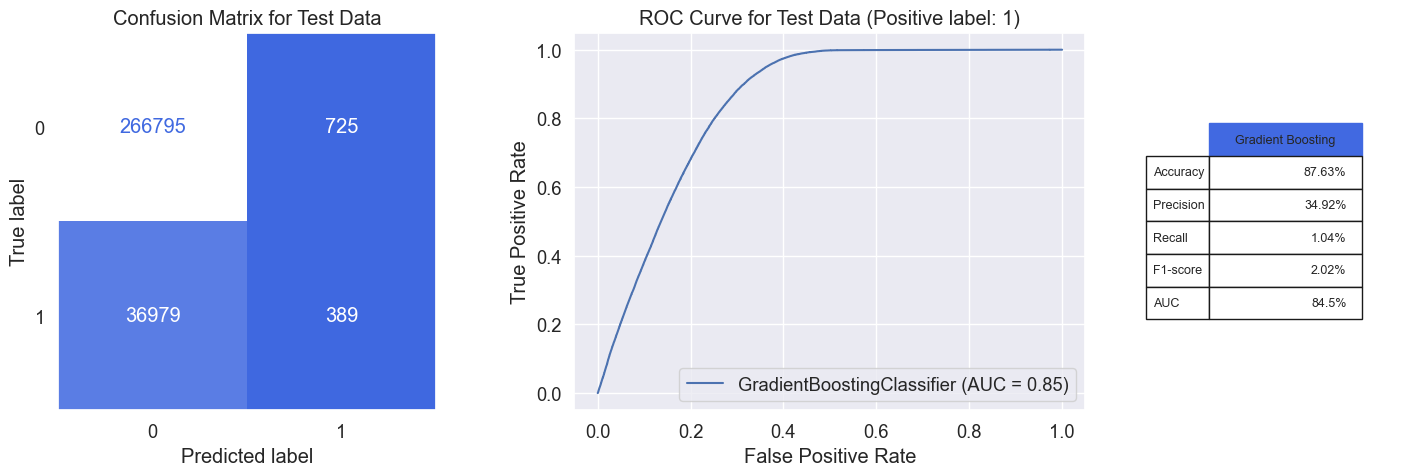

In [36]:
model_evaluation(gbc_final, X_train, X_test, y_train, y_test, 'Gradient Boosting')

In [116]:
# Save the final performance of Gradient Boosting classifier
gbc_result = metrics_calculator(gbc_final, X_test, y_test, 'Gradient Boosting')
gbc_result

,Gradient Boosting
Accuracy,87.71%
Precision,36.57%
Recall,0.53%
F1-score,1.04%
AUC,84.77%


Gradient Boosting model is not giving good recall and F1score. So it is not a good model


In [101]:
import pickle
pickle.dump(gbc_final,open('GradientBoostingModel.pkl','wb'))

## XGBoost - Model Building

XGBoost is a type of gradient boosting algorithm for tree-based machine learning models. It stands for eXtreme Gradient Boosting. XGBoost is a highly optimized implementation of gradient boosting and is designed to be fast and memory efficient.

XGBoost has several unique features compared to other gradient boosting implementations, such as:
Handling missing values
Parallel processing for training and prediction
Tree pruning for reducing overfitting
Regularization for preventing overfitting
These features make XGBoost a popular and powerful tool for solving many machine learning problemsv

In [104]:
# Perform train test split
X = df.drop(['Response','id','Policy_Sales_Channel'],axis=1)
y = df['Response']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

# Define imbalance ratio
ratio = sum(y_train==0)/sum(y_train==1) 

# Define the hyperparameter grid to search
xgb_param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 5, 10],
    'scale_pos_weight': [ratio, ratio*1.3, ratio*1.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'colsample_bylevel': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1],
    'max_delta_step': [0, 1, 2],
    'gamma': [0, 0.1, 1],
    'max_leaf_nodes': [2, 4, 6]
}


# Create the Decision Tree classifier as the base estimator
xgb_opt = XGBClassifier(random_state=0)

# Find the best hyperparameters from the tuning process
gbc_opt = tune_clf_hyperparameters(xgb_opt, xgb_param_grid, X_train, y_train)

[16:08:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "max_leaf_nodes" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:08:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Done
Best Hypermarameters:
 {'subsample': 0.8, 'scale_pos_weight': 7.1708434384263, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 1, 'max_leaf_nodes': 4, 'max_depth': 7, 'max_delta_step': 2, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 1.0, 'colsample_bylev


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.68      0.81    266110
           1       0.29      0.95      0.45     37110

    accuracy                           0.72    303220
   macro avg       0.64      0.82      0.63    303220
weighted avg       0.90      0.72      0.76    303220


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.67      0.80     66528
           1       0.28      0.91      0.43      9278

    accuracy                           0.70     75806
   macro avg       0.63      0.79      0.61     75806
weighted avg       0.90      0.70      0.75     75806



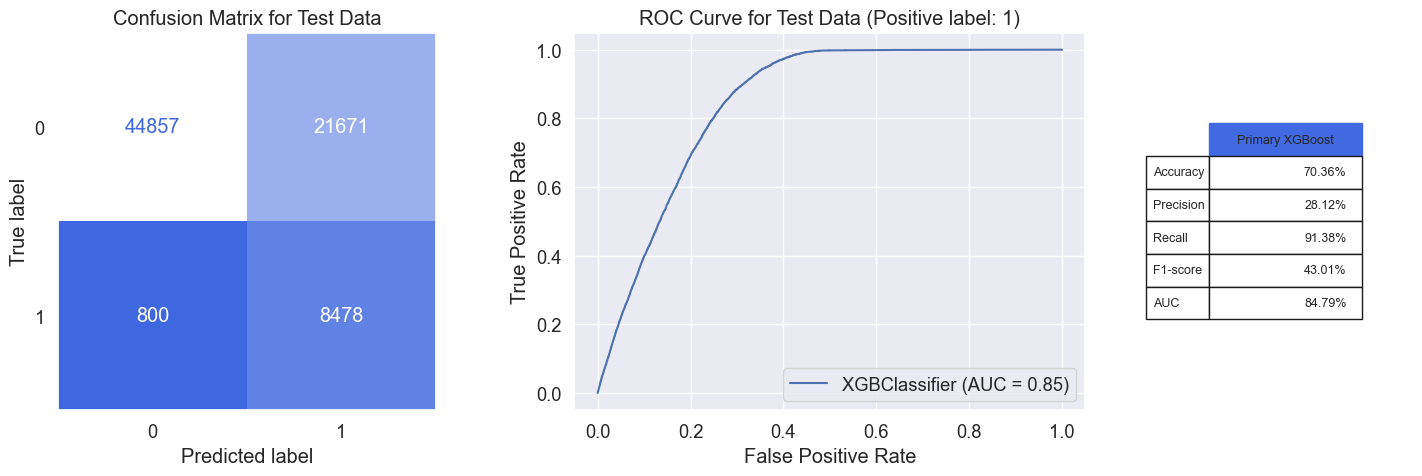

In [105]:
model_evaluation(gbc_opt, X_train, X_test, y_train, y_test, 'Primary XGBoost')

In [108]:
# Save the final performance of XGBoost classifier
xgb_result = metrics_calculator(gbc_opt, X_test, y_test, 'XGBoost')
xgb_result

,XGBoost
Accuracy,70.36%
Precision,28.12%
Recall,91.38%
F1-score,43.01%
AUC,84.79%


In [110]:
pickle.dump(gbc_opt,open('XGBosstModel.pkl','wb'))

XGBoosting algorithm has slightly import the F1Score but has tremendous change in Recall Score of the model. Lets create summary of all the models

In [129]:
ada_result

,AdaBoost
Accuracy,87.73%
Precision,41.04%
Recall,0.59%
F1-score,1.17%
AUC,84.49%


In [130]:
# Concatenate previous classifiers perfermance results into a single dataframe
results = pd.concat([logreg_result, logreg_result_featurescaling, dt_result, rf_result,et_result,
                     ada_result,gbc_result,xgb_result], axis=1).T

# Sort the dataframe in descending order based on F1-score values
results.sort_values(by='F1-score', ascending=False, inplace=True)

# Color the F1-score column
#results.style.applymap(lambda x: 'background-color: royalblue', subset='F1-score')

In [131]:
results

,Accuracy,Precision,Recall,F1-score,AUC
Random Forest,75.43%,30.72%,80.22%,44.42%,84.44%
Decision Tree,75.7%,30.5%,77.05%,43.7%,83.68%
Extra Trees,79.24%,32.71%,65.84%,43.7%,84.65%
XGBoost,70.36%,28.12%,91.38%,43.01%,84.79%
Logistic Regression,78.25%,31.28%,64.95%,42.23%,83.09%
Logistic Regression,64.62%,25.04%,94.85%,39.62%,83.08%
AdaBoost,87.73%,41.04%,0.59%,1.17%,84.49%
Gradient Boosting,87.71%,36.57%,0.53%,1.04%,84.77%


## Conclusion

Above analysis shows that Random Forest Classifier is giving the best F1 Score & Recall Score